In [30]:
    banglabook_df = pd.read_csv("/kaggle/input/banglabook/data/csv/train.csv", encoding="utf-8") 
    banglabook_df

,id,Book_Name,Writer_Name,Category,Rating,Review,Site,sentiment,label
0,19635,নেভার স্টপ লার্নিং (হার্ডকভার),আয়মান সাদিক,ছাত্রজীবন উন্নয়ন,5,মোটিভেশনাল ভিডিও দেখা শুরু হয়েছে ভাইয়ার ভিডিও ...,Rokomari,positive,2
1,31528,রাসুলুল্লাহ (স) এর নামায (১ম ও ২য় খণ্ড একত্রে...,আল্লামা মুহাম্মদ নাসীরুদ্দীন আলবানী (রহঃ),সালাত/নামায,1,"আসসালামু আলাইকুম।ভাইয়েরা, বইটা নিঃসন্দেহে অবশ্...",Rokomari,negative,0
2,9235,পোয়েটিক জাস্টিস (পেপারব্যাক),আগাথা ক্রিস্টি,"রহস্য, গোয়েন্দা, ভৌতিক, মিথ, থ্রিলার, ও অ্যাড...",5,"আগাথা ক্রিস্টির বিখ্যাত ক্রাইম নোভেল ""দ্য মার...",Rokomari,positive,2
3,89993,কমপ্লিট এডোবি ফটোশপ (সিডি সহ) (পেপারব্যাক),বাপ্পি আশরাফ,গ্রাফিক্স ডিজাইন ও মাল্টিমিডিয়া,5,দুর্দান্ত,Rokomari,positive,2
4,155762,মাগফিরাতের পথ ও পাথেয়,ইমাম ইবনু রজব হাম্বলি (রহঃ),আত্মশুদ্ধি ও অনুপ্রেরণা,5,বইঃ মাগফিরাতের পথ ও পাথেয়\nলেখক : ইমাম ইবনু রজ...,WafiLife,positive,2
...,...,...,...,...,...,...,...,...,...
110640,131529,হুমায়ূন আহমেদ : সাহিত্যের জীবন্ত পাঠশালা (হার...,শামীম আহমেদ ১ (সম্পাদক),সাহিত্য ও সাহিত্যিক,5,একটি গন্থ- এ যেন লেখকের নিজের লেখা 'সাহিত্যজীব...,Rokomari,positive,2
110641,155466,কিংবদন্তির কথা বলছি,আহমাদ সাব্বির,ইসলামী ব্যক্তিত্ব,5,ছোটবেলায় আমার আম্মাকে দেখতাম ‘মাসিক মদিনা’ পড়ত...,WafiLife,positive,2
110642,96094,আহকামে যিন্দেগী (পঞ্চম সংস্করণ) (হার্ডকভার),মাওলানা মুহাম্মদ হেমায়েত উদ্দীন,ইসলামি বিধি-বিধান ও মাসআলা-মাসায়েল,5,"বই তা অনেক ভালো,, আমল এর জন্য অনেক ভালো একটা বই",Rokomari,positive,2
110643,11430,কাস্টমার সার্ভিস ১.০ (হার্ডকভার),আনোয়ার এমডি হোসেইন,ক্যারিয়ার উন্নয়ন,5,বাংলাভাষায় কাস্টমার সার্ভিসের উপর খুব বেশি বই...,Rokomari,positive,2


In [ ]:
# Install required packages
!pip install transformers datasets torch -q
!pip install tensorflow==2.10.1 -q
!pip install textattack -q
!pip install huggingface_hub -q
!pip install scikit-learn matplotlib seaborn -q


In [ ]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset as TorchDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    AutoConfig,
    get_linear_schedule_with_warmup
)
from datasets import load_dataset, Dataset
import tensorflow as tf
import textattack
from textattack.models.wrappers import ModelWrapper
from textattack.attack_recipes import DeepWordBugGao2018
from textattack import Attacker
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


In [ ]:
class BanglaTransformerConfig:
    """Configuration for Bangla transformer fine-tuning"""
    def __init__(self):
        # Model configurations
        self.pretrained_models = {
            'bangla_bert': 'sagorsarker/bangla-bert-base',
            'cse_banglabert': 'csebuetnlp/banglabert', 
            'multilingual_bert': 'bert-base-multilingual-cased',
            'bangla_electra': 'Kowsher/bangla-electra-bert-base'
        }
        
        # Training configurations
        self.model_name = 'sagorsarker/bangla-bert-base'  # Default model
        self.max_length = 512
        self.batch_size = 16
        self.learning_rate = 2e-5
        self.num_epochs = 3
        self.weight_decay = 0.01
        self.warmup_ratio = 0.1
        self.num_labels = 3  # positive, negative, neutral
        self.gradient_accumulation_steps = 1
        self.max_grad_norm = 1.0
        self.save_steps = 500
        self.eval_steps = 500
        self.logging_steps = 100


In [ ]:
class BanglaDataset(TorchDataset):
    """Custom PyTorch Dataset for Bangla sentiment data"""
    
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        # Tokenize
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

def load_bangla_datasets():
    """Load various Bangla sentiment datasets"""
    datasets = {}
    

    banglabook = load_dataset("Starscream-11813/BanglaBook", split='train')
    banglabook_df = pd.read_csv("/kaggle/input/banglabook/data/csv/train.csv", encoding="utf-8") 
        
        # Filter only Bangla reviews and clean data
    banglabook_clean = banglabook_df
    #[banglabook_df['language'] == 'bangla'].copy()
    #banglabook_clean = banglabook_clean.dropna(subset=['review', 'sentiment'])
        
        # Map sentiment labels
    #sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
    #banglabook_clean['label'] = banglabook_clean['sentiment'].map(sentiment_mapping)
    #banglabook_clean = banglabook_clean.dropna(subset=['label'])
        
    datasets['banglabook'] = banglabook_clean[['Review', 'label']].rename(columns={'Review': 'text'})
    print(f"BanglaBook dataset loaded: {len(datasets['banglabook'])} samples")
        
  
    if not datasets:
        print("Creating sample Bangla dataset...")
        sample_data = {
            'text': [
                'এই সিনেমাটি অসাধারণ ছিল! আমি খুবই উপভোগ করেছি।',  # Positive
                'খুবই খারাপ অভিজ্ঞতা হয়েছে। সম্পূর্ণ সময় নষ্ট।',      # Negative
                'এটি একটি সাধারণ বই। ভালো বা খারাপ কিছুই না।',        # Neutral
                'চমৎকার পরিচালনা এবং অভিনয়। দেখার মতো।',           # Positive
                'বিরক্তিকর এবং নিরস। আর দেখতে চাই না।',            # Negative
                'বইটি ঠিক আছে। কিছু ভালো দিক আছে, কিছু খারাপ।',     # Neutral
                'অত্যন্ত সুন্দর গল্প। মন ছুঁয়ে গেছে।',            # Positive
                'সম্পূর্ণ বাজে। পয়সা ফেরত চাই।',                  # Negative
                'মোটামুটি ভালো। খুব বেশি প্রত্যাশা না করলে চলে।',   # Neutral
                'জীবনে দেখা সেরা সিনেমা। অবশ্যই দেখুন।'           # Positive
            ] * 100,  # Repeat to create more samples
            'label': [2, 0, 1, 2, 0, 1, 2, 0, 1, 2] * 100  # 0=negative, 1=neutral, 2=positive
        }
        datasets['sample'] = pd.DataFrame(sample_data)
        print(f"Sample dataset created: {len(datasets['sample'])} samples")
    
    return datasets


ERROR: Could not find a version that satisfies the requirement tensorflow==2.10.1 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.10.1
Using device: cuda
Choose training mode:
1. Standard training only
2. Standard + Adversarial training


Enter choice (1 or 2):  2



🚀 Running adversarial training pipeline...
🚀 Starting Bangla Sentiment Analysis with Adversarial Training
Loading Bangla sentiment datasets...
BanglaBook dataset loaded: 110645 samples
Using BanglaBook dataset with 5000 samples

Dataset splits:
  Train samples: 3200
  Validation samples: 800
  Test samples: 1000

PHASE 1: TRAINING ORIGINAL MODEL
Fine-tuning sagorsarker/bangla-bert-base with custom training loop...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sagorsarker/bangla-bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Preparing data loaders...
Setting up optimizer and scheduler...
Training for 3 epochs...
Total training steps: 600
Gradient accumulation steps: 1

Epoch 1/3
--------------------------------------------------



Training Epoch 1:  50%|█████     | 100/200 [01:41<01:42,  1.02s/it, Loss=0.3081, LR=1.85e-05]

Step 100: Average train loss: 0.5490



Training Epoch 1: 100%|██████████| 200/200 [03:24<00:00,  1.02s/it, Loss=0.5282, LR=1.48e-05]


Step 200: Average train loss: 0.4646
Running validation...



Evaluating: 100%|██████████| 50/50 [00:12<00:00,  3.92it/s]


Epoch 1 Results:
  Average train loss: 0.4646
  Validation loss: 0.4004
  Validation accuracy: 0.8900
New best validation accuracy: 0.8900
The OrderedVocab you are attempting to save contains holes for indices [1015, 1016, 1017, 1018, 1053, 1054, 1055, 1056, 1057, 1060, 1061, 1062, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1099, 1101, 1112, 1113, 1556, 1557, 1568], your vocabulary could be corrupted !
Model saved to: ./best_bangla_sentiment_model
The OrderedVocab you are attempting to save contains holes for indices [1015, 1016, 1017, 1018, 1053, 1054, 1055, 1056, 1057, 1060, 1061, 1062, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1099, 1101, 1112, 1113, 1556, 1557, 1568], your vocabulary could be corrupt


Training Epoch 2:  50%|█████     | 100/200 [01:42<01:42,  1.02s/it, Loss=0.3295, LR=1.11e-05]

Step 300: Average train loss: 0.3339



Training Epoch 2: 100%|██████████| 200/200 [03:24<00:00,  1.02s/it, Loss=0.6298, LR=7.41e-06]


Step 400: Average train loss: 0.3113
Running validation...



Evaluating: 100%|██████████| 50/50 [00:12<00:00,  3.91it/s]


Epoch 2 Results:
  Average train loss: 0.3113
  Validation loss: 0.3693
  Validation accuracy: 0.9012
New best validation accuracy: 0.9012
The OrderedVocab you are attempting to save contains holes for indices [1015, 1016, 1017, 1018, 1053, 1054, 1055, 1056, 1057, 1060, 1061, 1062, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1099, 1101, 1112, 1113, 1556, 1557, 1568], your vocabulary could be corrupted !
Model saved to: ./best_bangla_sentiment_model
The OrderedVocab you are attempting to save contains holes for indices [1015, 1016, 1017, 1018, 1053, 1054, 1055, 1056, 1057, 1060, 1061, 1062, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1099, 1101, 1112, 1113, 1556, 1557, 1568], your vocabulary could be corrupt


Training Epoch 3:  50%|█████     | 100/200 [01:42<01:42,  1.03s/it, Loss=0.0305, LR=3.70e-06]

Step 500: Average train loss: 0.2193



Training Epoch 3: 100%|██████████| 200/200 [03:24<00:00,  1.02s/it, Loss=0.2045, LR=0.00e+00]


Step 600: Average train loss: 0.2340
Running validation...



Evaluating: 100%|██████████| 50/50 [00:12<00:00,  3.91it/s]


Epoch 3 Results:
  Average train loss: 0.2340
  Validation loss: 0.3864
  Validation accuracy: 0.8962
The OrderedVocab you are attempting to save contains holes for indices [1015, 1016, 1017, 1018, 1053, 1054, 1055, 1056, 1057, 1060, 1061, 1062, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1099, 1101, 1112, 1113, 1556, 1557, 1568], your vocabulary could be corrupted !
Model saved to: ./bangla_sentiment_checkpoint_epoch_3

Training completed!
Best validation accuracy: 0.9012

Plotting original model training history...


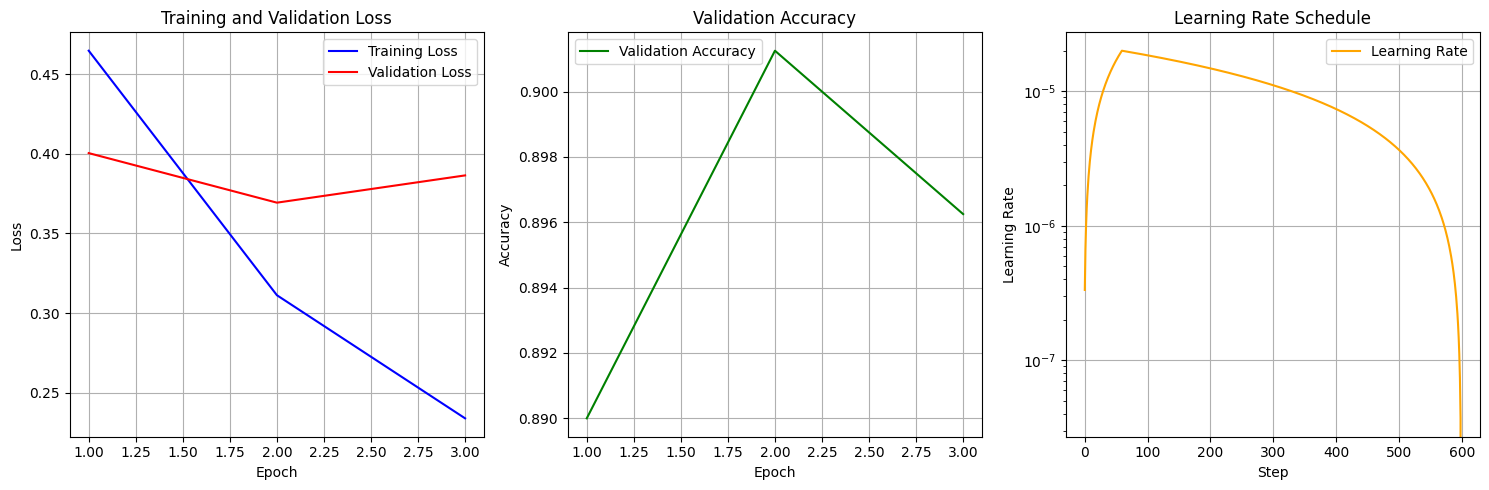


Evaluating original model...



Testing: 100%|██████████| 63/63 [00:16<00:00,  3.90it/s]


Test Accuracy: 0.8950

Classification Report:
              precision    recall  f1-score   support

    Negative       0.47      0.43      0.45        60
     Neutral       0.00      0.00      0.00        46
    Positive       0.93      0.97      0.95       894

    accuracy                           0.90      1000
   macro avg       0.47      0.47      0.47      1000
weighted avg       0.86      0.90      0.88      1000



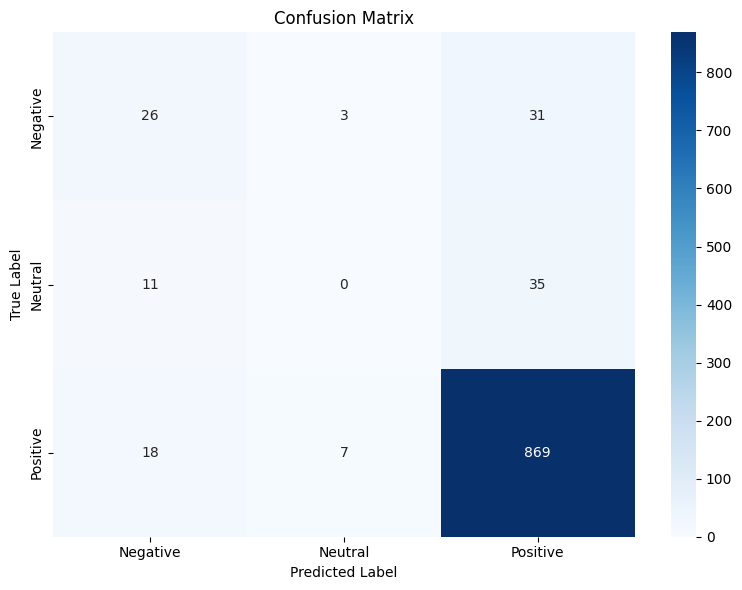


Testing original model predictions...
Sample Predictions:
--------------------------------------------------
Text: এই সিনেমাটি অসাধারণ ছিল! আমি খুবই পছন্দ করেছি।
Predicted: Positive (Confidence: 0.9915)
--------------------------------------------------
Text: খুবই খারাপ অভিজ্ঞতা। সম্পূর্ণ সময় নষ্ট হয়েছে।
Predicted: Negative (Confidence: 0.7948)
--------------------------------------------------
Text: বইটি ঠিক আছে। ভালো বা খারাপ কিছুই বিশেষ নয়।
Predicted: Negative (Confidence: 0.5108)
--------------------------------------------------
Text: চমৎকার পরিচালনা এবং চমৎকার অভিনয়।
Predicted: Positive (Confidence: 0.9912)
--------------------------------------------------
Text: বিরক্তিকর এবং নিরস কাহিনী।
Predicted: Positive (Confidence: 0.9433)
--------------------------------------------------

PHASE 2: ADVERSARIAL TRAINING PIPELINE
Generating adversarial examples for train subset (this can be slow)...



  0%|          | 1/500 [00:00<01:00,  8.20it/s]
[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:   0%|          | 1/500 [00:00<01:03,  7.90it/s]
[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:   0%|          | 2/500 [00:00<00:47, 10.43it/s]
[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:   1%|          | 3/500 [00:00<00:47, 10.40it/s]
[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:   1%|          | 3/500 [00:00<00:48, 10.28it/s]
[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:   1%|          | 4/500 [00:00<01:17,  6.41it/s]
[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:   1%|          | 5/500 [00:02<03:42,  2.22it/s]
[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:   1%|          | 5/500 [00:02<03:43,  2.21it/s]
[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:   1%|          | 6/500 [00:04<05:48,  1.42it/s]
[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:   1%|▏         | 7/500 [00:06<07:05,  1.16it/s]
[Succeeded / Failed / Skipped / T

[warning] bulk attack failed (No features in text.). Falling back to per-sample loop...




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.82it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  8.61it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 15.82it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 10.35it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.02it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.62s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.81s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.79s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.09s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 15.34it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.26it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]
[Succeeded / Failed / Skipped / Total] 42 / 53 / 8 / 103:  21%|██        | 104/500 [01:17<04:54,  1.34it/s]

100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.23it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  7.06it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.03it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.78s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.19it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  8.95it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.01it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.79s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.56s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.56s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1: 100%|██████████| 1/1 [00:00<00:00, 92.59it/s] 
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.70s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 38.90it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.52s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.53s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.04it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.96s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.81it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  5.71it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 15.50it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 10.21it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.54it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  4.48it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 10.61it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 38.45it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.89s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 23.54it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1: 100%|██████████| 1/1 [00:00<00:00, 107.78it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 12.34it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.67it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.59it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1: 100%|██████████| 1/1 [00:00<00:00, 93.59it/s] 
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 10.75it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 12.75it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.60s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.61s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.99it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  5.89it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.55s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.95s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.95s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.87it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  6.74it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.50it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.92it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 11.44it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.61s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.61s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 40.62it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.61s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.61s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.82s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 20.70it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.69s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.47it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.38it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  5.29it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.45it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 97.75it/s] 
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 20.35it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1: 100%|██████████| 1/1 [00:00<00:00, 96.07it/s] 
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.86it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  9.58it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.00it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1: 100%|██████████| 1/1 [00:00<00:00, 99.02it/s] 
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.71s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1: 100%|██████████| 1/1 [00:00<00:00, 98.23it/s] 
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 13.87it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 39.00it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 11.08it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.32it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.64s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.06s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1: 100%|██████████| 1/1 [00:00<00:00, 99.30it/s] 
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 20.87it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.83s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 15.83it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.48it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  3.43it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 12.67it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 10.79it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.07it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1: 100%|██████████| 1/1 [00:00<00:00, 95.63it/s] 
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.59it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.43s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 91.05it/s] 
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1: 100%|██████████| 1/1 [00:00<00:00, 103.29it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 93.65it/s] 
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 10.52it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.23it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.00it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  7.81it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 14.98it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.79it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  9.46it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.01s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 11.30it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.69s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 39.41it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 20.34it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.88it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 15.50it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.52it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  7.36it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.75it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  9.49it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 25.52it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.66s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 20.46it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.89s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 30.72it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.01s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.47s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1: 100%|██████████| 1/1 [00:00<00:00, 99.82it/s] 
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.04it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.18it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.13it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.06it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  5.96it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.11s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:02<00:00,  2.11s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.98it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  7.79it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.78s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.74s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.86it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 40.78it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.78it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  9.46it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.00it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.86it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 11.32it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.85s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 13.19it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 16.57it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.74s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.40s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.79s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.82s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.74it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1: 100%|██████████| 1/1 [00:00<00:00, 92.88it/s] 
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 21.01it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.22s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:02<00:00,  2.22s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.46s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.28s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.53s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.53s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.96it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.50s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.50s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.20it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  5.13it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 13.97it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.37it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1: 100%|██████████| 1/1 [00:00<00:00, 93.81it/s] 
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 39.33it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1: 100%|██████████| 1/1 [00:00<00:00, 94.50it/s] 
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 39.49it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 13.47it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 14.65it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.56s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.57s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1: 100%|██████████| 1/1 [00:00<00:00, 94.86it/s] 
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 10.29it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.68it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  5.58it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.69s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.05it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.80s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.64s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.25s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 15.60it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 13.96it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 15.28it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 14.93it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.71s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 37.87it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.47it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  8.21it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.86s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 12.50it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.26it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 10.24it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.67s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.88s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.55s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 38.54it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 15.69it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.11it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  6.94it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1: 100%|██████████| 1/1 [00:00<00:00, 92.64it/s] 
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.93it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.30it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  7.14it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.68it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  9.33it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 23.66it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.49it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 96.30it/s] 
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.46it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  3.43it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.86s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.60it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  7.44it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.67it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  6.51it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.01it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.52it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  6.37it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 20.75it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 37.55it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.31s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.66it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.88it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  9.61it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.39it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  5.31it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.91it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  5.81it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.93it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1: 100%|██████████| 1/1 [00:00<00:00, 97.45it/s] 
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.15it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  6.95it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.55it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1: 100%|██████████| 1/1 [00:00<00:00, 92.24it/s] 
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.66s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.59it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.87s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 40.09it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.67s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.96it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.04it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  6.90it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.53s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.22it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.03it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  8.78it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.69it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 21.20it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.28it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  9.00it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 15.63it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.75s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 38.41it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 11.27it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.48s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.33it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.36it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.88s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.53it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  4.47it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 24.47it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1: 100%|██████████| 1/1 [00:00<00:00, 90.01it/s] 
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.92s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.09it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.93s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.93s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.60s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.60s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 15.48it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.36it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 15.01it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.40s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.62it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  6.49it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.03it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.72it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.90s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.50s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.50s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.25it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  3.21it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.06it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.87it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.23it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.82s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 20.37it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.66it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.05it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.94s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.99it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  5.88it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.67it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  5.56it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 16.91it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.54s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 11.58it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1: 100%|██████████| 1/1 [00:00<00:00, 91.72it/s] 
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.64it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  7.48it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.95it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.08it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  8.84it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 20.37it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.48it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.17it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.76s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 12.64it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 24.60it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.78s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.82s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 39.45it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 20.51it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.79s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.56s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.57s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1: 100%|██████████| 1/1 [00:00<00:00, 100.24it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.02s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 15.31it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.65it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  8.45it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1: 100%|██████████| 1/1 [00:00<00:00, 97.44it/s] 
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.99it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  5.89it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.84s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 37.77it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1: 100%|██████████| 1/1 [00:00<00:00, 97.26it/s] 
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.58s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.58s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.63it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 17.86it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.04it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.23it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.49it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.77it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1: 100%|██████████| 1/1 [00:00<00:00, 90.65it/s] 
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 15.91it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.92s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.93s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.35it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  5.24it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.09s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.40s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 10.56it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.02s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.76s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 38.09it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.65it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  9.40it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 17.51it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.66s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 24.53it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.99it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 39.03it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 20.43it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.64it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 54.15it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.56s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.56s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.02it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  7.85it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 15.70it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.09s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.90it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.02s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.68s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.07it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.00it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.93s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.93s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.93s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 15.44it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 11.37it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.39s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.36it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.45it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  5.36it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 14.10it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.47s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 98.17it/s] 
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.22s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:02<00:00,  2.22s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.81it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  5.72it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.29it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  3.25it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.90s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.43s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1: 100%|██████████| 1/1 [00:00<00:00, 88.05it/s] 
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 10.34it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.87s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.67s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.23it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 28.59it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.14it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  6.03it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.53it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.59s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.59s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.02s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.00s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 12.12it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 23.85it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.31it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  9.06it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.88s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 10.55it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 15.33it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.70it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  6.57it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.56it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1: 100%|██████████| 1/1 [00:00<00:00, 96.06it/s] 
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 13.69it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 14.43it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.66it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.23it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.18it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.77s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 12.65it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.78it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.72s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 38.19it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 10.33it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.82it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  5.73it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.48s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.04s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.89s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 38.81it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1: 100%|██████████| 1/1 [00:00<00:00, 88.33it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.93s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.47it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  7.32it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.71s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.67it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  6.52it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.98s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.00s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.00s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.17it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.64it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  5.55it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.88it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.32it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 39.67it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.53it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  9.20it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.81s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.20it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  3.16it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1: 100%|██████████| 1/1 [00:00<00:00, 90.86it/s] 
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 10.32it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.53it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1: 100%|██████████| 1/1 [00:00<00:00, 95.86it/s] 
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.37it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  5.28it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 90.27it/s] 
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.48it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  5.39it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1: 100%|██████████| 1/1 [00:00<00:00, 91.38it/s] 
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.34it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  8.13it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 14.58it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.76it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  9.45it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.41it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  5.30it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.88it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.82s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.06s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.37it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1: 100%|██████████| 1/1 [00:00<00:00, 96.77it/s] 
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 11.09it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.66it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 15.08it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.01s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.70s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.90s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.49s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]
[Succeeded / Failed / Skipped / Total] 42 / 53 / 8 / 103:  21%|██        | 104/500 [06:41<25:30,  3.86s/it]
textattack: CSVLogger exiting without calling flush().
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




Adversarial train examples found: 215
Generating adversarial examples for test subset (this can be slow)...



  0%|          | 1/200 [00:00<00:21,  9.45it/s]
[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:   0%|          | 1/200 [00:00<00:21,  9.07it/s]
[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:   1%|          | 2/200 [00:01<02:18,  1.43it/s]
[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:   1%|          | 2/200 [00:01<02:18,  1.43it/s]
[Succeeded / Failed / Skipped / Total] 1 / 1 / 1 / 3:   2%|▏         | 3/200 [00:01<01:32,  2.12it/s]
[Succeeded / Failed / Skipped / Total] 1 / 2 / 1 / 4:   2%|▏         | 4/200 [00:01<01:12,  2.69it/s]
[Succeeded / Failed / Skipped / Total] 1 / 2 / 1 / 4:   2%|▎         | 5/200 [00:02<01:40,  1.93it/s]
[Succeeded / Failed / Skipped / Total] 2 / 2 / 1 / 5:   2%|▎         | 5/200 [00:02<01:41,  1.93it/s]
[Succeeded / Failed / Skipped / Total] 2 / 3 / 1 / 6:   3%|▎         | 6/200 [00:02<01:24,  2.29it/s]
[Succeeded / Failed / Skipped / Total] 2 / 4 / 1 / 7:   4%|▎         | 7/200 [00:02<01:17,  2.50it/s]
[Succeeded / Failed / Skipped / T

[warning] bulk attack failed (No features in text.). Falling back to per-sample loop...




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.89it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  9.60it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1: 100%|██████████| 1/1 [00:00<00:00, 95.15it/s] 
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 15.34it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 38.29it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.06it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  5.96it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.81s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.34s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.17it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  7.02it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.72it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.68s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 37.01it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 20.38it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.15it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  3.12it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1: 100%|██████████| 1/1 [00:00<00:00, 94.01it/s] 
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 94.42it/s] 
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.45it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1: 100%|██████████| 1/1 [00:00<00:00, 84.74it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.21s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 11.30it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 11.28it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 15.10it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.88s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]
[Succeeded / Failed / Skipped / Total] 8 / 8 / 2 / 18:  10%|▉         | 19/200 [00:25<04:02,  1.34s/it]

100%|██████████| 1/1 [00:00<00:00,  4.03it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.58it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  9.34it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.94it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  6.80it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.13s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.64s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 11.43it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.45it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 10.53it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.78s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.97it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.52it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  8.33it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 37.73it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.12it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 24.82it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 15.45it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.00it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  8.70it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 22.85it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1: 100%|██████████| 1/1 [00:00<00:00, 83.85it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 30.46it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.27it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 15.95it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.37it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  7.20it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.97s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.00it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.00s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.08it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.40s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.12it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  3.09it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.86s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 13.76it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.28it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  7.08it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.49it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.28it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.86s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.29it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.22it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  6.10it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.20it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.65it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  5.53it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.96s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 13.87it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.58it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  5.50it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 15.04it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 10.85it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.82s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.12it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.24s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.76it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  5.65it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.73it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  8.52it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 15.61it/s]


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.14s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:02<00:00,  2.14s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.87s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.00it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  5.90it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.13s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:02<00:00,  2.14s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1: 100%|██████████| 1/1 [00:00<00:00, 91.75it/s] 
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.53it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.69it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.93it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.92s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.09it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 21.07it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.90it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1: 100%|██████████| 1/1 [00:00<00:00, 104.81it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1: 100%|██████████| 1/1 [00:00<00:00, 99.14it/s] 
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1: 100%|██████████| 1/1 [00:00<00:00, 102.87it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1: 100%|██████████| 1/1 [00:00<00:00, 96.89it/s] 
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.69it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  5.60it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 93.89it/s] 
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 15.47it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.79s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.53it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.27it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.94s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1: 100%|██████████| 1/1 [00:00<00:00, 92.11it/s] 
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 93.54it/s] 
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1: 100%|██████████| 1/1 [00:00<00:00, 94.31it/s] 
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.45it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  8.25it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 38.40it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1: 100%|██████████| 1/1 [00:00<00:00, 93.65it/s] 


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 23.76it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1: 100%|██████████| 1/1 [00:00<00:00, 97.12it/s] 
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.46it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 20.54it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.74s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.84it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 39.69it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.36it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.25it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.36it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  7.21it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.37it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 12.68it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1: 100%|██████████| 1/1 [00:00<00:00, 92.92it/s] 
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.58s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.58s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1: 100%|██████████| 1/1 [00:00<00:00, 89.43it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 15.55it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 30.82it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.76it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 39.92it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 10.29it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 38.36it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.52s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 14.86it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.73it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.63s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.60it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.07it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  8.78it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 15.37it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.77it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.74it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  9.47it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.93it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.83it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.85it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  7.68it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.88s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.53s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.53s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1: 100%|██████████| 1/1 [00:00<00:00, 98.06it/s] 
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 14.04it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.95s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.95s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.39it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.80it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  5.69it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.16it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  5.06it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.50s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.50s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.59it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  5.49it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.80it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 12.03it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.55s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.56s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1: 100%|██████████| 1/1 [00:00<00:00, 94.04it/s] 
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.58it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.58it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.60it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  7.40it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.67it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 15.26it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1: 100%|██████████| 1/1 [00:00<00:00, 59.32it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.73it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1: 100%|██████████| 1/1 [00:00<00:00, 98.09it/s] 
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.05s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 37.43it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.33it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.67s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.78s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 12.34it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.69it/s]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00, 98.36it/s] 
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.09it/s]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1: 100%|██████████| 1/1 [00:00<00:00,  6.95it/s]
[Succeeded / Failed / Skipped / Total] 8 / 8 / 2 / 18:  10%|▉         | 19/200 [01:56<18:33,  6.15s/it]
textattack: CSVLogger exiting without calling flush().




Adversarial test examples found: 80
Adversarial labeled train samples: 215
Adversarial labeled test samples:  80
Robust train size: 3415 (clean + adv)
Robust val size:   880 (val + adv)
Starting adversarial fine-tuning on combined dataset...
Preparing data loaders...
Setting up optimizer and scheduler...
Training for 2 epochs...
Total training steps: 428
Gradient accumulation steps: 1

Epoch 1/2
--------------------------------------------------



Training Epoch 1:  47%|████▋     | 100/214 [01:42<01:56,  1.03s/it, Loss=0.2434, LR=1.70e-05]

Step 100: Average train loss: 0.2528



Training Epoch 1:  93%|█████████▎| 200/214 [03:25<00:14,  1.03s/it, Loss=0.4740, LR=1.18e-05]

Step 200: Average train loss: 0.2558



Training Epoch 1: 100%|██████████| 214/214 [03:39<00:00,  1.02s/it, Loss=0.0865, LR=1.11e-05]


Running validation...



Evaluating: 100%|██████████| 55/55 [00:14<00:00,  3.91it/s]


Epoch 1 Results:
  Average train loss: 0.2583
  Validation loss: 0.3904
  Validation accuracy: 0.8909
New best validation accuracy: 0.8909
The OrderedVocab you are attempting to save contains holes for indices [1015, 1016, 1017, 1018, 1053, 1054, 1055, 1056, 1057, 1060, 1061, 1062, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1099, 1101, 1112, 1113, 1556, 1557, 1568], your vocabulary could be corrupted !
Model saved to: ./best_bangla_sentiment_model
The OrderedVocab you are attempting to save contains holes for indices [1015, 1016, 1017, 1018, 1053, 1054, 1055, 1056, 1057, 1060, 1061, 1062, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1099, 1101, 1112, 1113, 1556, 1557, 1568], your vocabulary could be corrupt


Training Epoch 2:  40%|████      | 86/214 [01:28<02:11,  1.03s/it, Loss=0.1192, LR=6.63e-06]

Step 300: Average train loss: 0.1731



Training Epoch 2:  87%|████████▋ | 186/214 [03:11<00:28,  1.02s/it, Loss=0.1054, LR=1.45e-06]

Step 400: Average train loss: 0.1725



Training Epoch 2: 100%|██████████| 214/214 [03:39<00:00,  1.03s/it, Loss=0.6819, LR=0.00e+00]


Running validation...



Evaluating: 100%|██████████| 55/55 [00:14<00:00,  3.91it/s]


Epoch 2 Results:
  Average train loss: 0.1804
  Validation loss: 0.4450
  Validation accuracy: 0.8955
New best validation accuracy: 0.8955
The OrderedVocab you are attempting to save contains holes for indices [1015, 1016, 1017, 1018, 1053, 1054, 1055, 1056, 1057, 1060, 1061, 1062, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1099, 1101, 1112, 1113, 1556, 1557, 1568], your vocabulary could be corrupted !
Model saved to: ./best_bangla_sentiment_model
The OrderedVocab you are attempting to save contains holes for indices [1015, 1016, 1017, 1018, 1053, 1054, 1055, 1056, 1057, 1060, 1061, 1062, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1099, 1101, 1112, 1113, 1556, 1557, 1568], your vocabulary could be corrupt


Testing: 100%|██████████| 63/63 [00:16<00:00,  3.87it/s]


Test Accuracy: 0.9020

Classification Report:
              precision    recall  f1-score   support

    Negative       0.58      0.35      0.44        60
     Neutral       0.23      0.07      0.10        46
    Positive       0.92      0.98      0.95       894

    accuracy                           0.90      1000
   macro avg       0.58      0.47      0.50      1000
weighted avg       0.87      0.90      0.88      1000



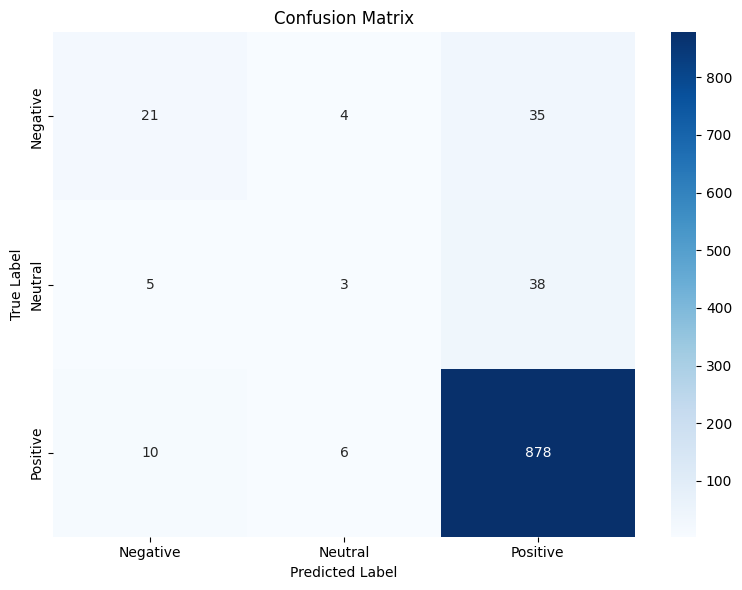


FINAL RESULTS SUMMARY:
Original Model Accuracy: 0.8950
Robust Model Accuracy:   0.9020
Accuracy Change:         +0.0070

📋 COMPREHENSIVE REPORT GENERATED
-----------------------------------
Robust Model - Adversarial Data Accuracy:   0.9000
Robustness Improvement: +0.0000

PERFORMANCE DROPS (Clean vs Adversarial):
----------------------------------------
Original Model Drop: -0.0050
Robust Model Drop:   0.0020
Drop Reduction:      -0.0070

SAVED MODEL FILES:

🎉 Complete adversarial training pipeline finished!
📊 Check the generated reports and visualizations:
   - robustness_comparison.png
   - training_history.png
   - comprehensive_adversarial_dataset.csv
   - robustness_evaluation_results.csv
   - final_model_comparison_report.txt

🔄 Final side-by-side comparison:

🔍 SIDE-BY-SIDE MODEL COMPARISON
Text                                     Original        Robust          Match     
----------------------------------------------------------------------
এই সিনেমাটি অসাধারণ ছিল! আমি খুবই 

In [36]:





class BanglaTransformerTrainer:
    """Custom trainer for Bangla transformer fine-tuning"""
    
    def __init__(self, model, tokenizer, config):
        self.model = model
        self.tokenizer = tokenizer
        self.config = config
        self.device = device
        
        # Move model to device
        self.model.to(self.device)
        
        # Training history
        self.train_losses = []
        self.val_losses = []
        self.val_accuracies = []
        self.learning_rates = []
        
    def prepare_data_loaders(self, train_data, val_data):
        """Prepare PyTorch data loaders"""
        
        # Create datasets
        train_dataset = BanglaDataset(
            train_data['text'].values,
            train_data['label'].values,
            self.tokenizer,
            self.config.max_length
        )
        
        val_dataset = BanglaDataset(
            val_data['text'].values,
            val_data['label'].values,
            self.tokenizer,
            self.config.max_length
        )
        
        # Create data loaders
        train_loader = DataLoader(
            train_dataset,
            batch_size=self.config.batch_size,
            shuffle=True,
            num_workers=2,
            pin_memory=True if torch.cuda.is_available() else False
        )
        
        val_loader = DataLoader(
            val_dataset,
            batch_size=self.config.batch_size,
            shuffle=False,
            num_workers=2,
            pin_memory=True if torch.cuda.is_available() else False
        )
        
        return train_loader, val_loader
    
    def setup_optimizer_and_scheduler(self, train_loader):
        """Setup optimizer and learning rate scheduler"""
        
        # Calculate total steps
        total_steps = len(train_loader) * self.config.num_epochs // self.config.gradient_accumulation_steps
        warmup_steps = int(total_steps * self.config.warmup_ratio)
        
        # Optimizer
        optimizer = optim.AdamW(
            self.model.parameters(),
            lr=self.config.learning_rate,
            weight_decay=self.config.weight_decay,
            eps=1e-8
        )
        
        # Scheduler
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=warmup_steps,
            num_training_steps=total_steps
        )
        
        return optimizer, scheduler, total_steps
    
    def evaluate(self, val_loader):
        """Evaluate model on validation set"""
        
        self.model.eval()
        total_loss = 0
        predictions = []
        true_labels = []
        
        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Evaluating"):
                # Move batch to device
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)
                
                # Forward pass
                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )
                
                loss = outputs.loss
                logits = outputs.logits
                
                total_loss += loss.item()
                
                # Get predictions
                batch_predictions = torch.argmax(logits, dim=-1)
                predictions.extend(batch_predictions.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())
        
        avg_loss = total_loss / len(val_loader)
        accuracy = accuracy_score(true_labels, predictions)
        
        return avg_loss, accuracy
    
    def save_model(self, save_path, epoch=None):
        """Save model and tokenizer"""
        
        if epoch is not None:
            save_path = f"{save_path}_epoch_{epoch}"
        
        os.makedirs(save_path, exist_ok=True)
        
        # Save model
        self.model.save_pretrained(save_path)
        self.tokenizer.save_pretrained(save_path)
        
        # Save training config
        config_dict = {
            'model_name': self.config.model_name,
            'max_length': self.config.max_length,
            'num_labels': self.config.num_labels,
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'val_accuracies': self.val_accuracies
        }
        
        with open(os.path.join(save_path, 'training_config.json'), 'w') as f:
            json.dump(config_dict, f, indent=2)
        
        print(f"Model saved to: {save_path}")
    
    def train(self, train_data, val_data):
        """Main training loop"""
        
        print("Preparing data loaders...")
        train_loader, val_loader = self.prepare_data_loaders(train_data, val_data)
        
        print("Setting up optimizer and scheduler...")
        optimizer, scheduler, total_steps = self.setup_optimizer_and_scheduler(train_loader)
        
        print(f"Training for {self.config.num_epochs} epochs...")
        print(f"Total training steps: {total_steps}")
        print(f"Gradient accumulation steps: {self.config.gradient_accumulation_steps}")
        
        # Training loop
        global_step = 0
        best_val_accuracy = 0
        
        for epoch in range(self.config.num_epochs):
            print(f"\nEpoch {epoch + 1}/{self.config.num_epochs}")
            print("-" * 50)
            
            # Training phase
            self.model.train()
            total_train_loss = 0
            optimizer.zero_grad()
            
            progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch + 1}")
            
            for step, batch in enumerate(progress_bar):
                # Move batch to device
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)
                
                # Forward pass
                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )
                
                loss = outputs.loss
                
                # Scale loss for gradient accumulation
                if self.config.gradient_accumulation_steps > 1:
                    loss = loss / self.config.gradient_accumulation_steps
                
                # Backward pass
                loss.backward()
                total_train_loss += loss.item()
                
                # Update weights
                if (step + 1) % self.config.gradient_accumulation_steps == 0:
                    # Clip gradients
                    torch.nn.utils.clip_grad_norm_(
                        self.model.parameters(), 
                        self.config.max_grad_norm
                    )
                    
                    optimizer.step()
                    scheduler.step()
                    optimizer.zero_grad()
                    global_step += 1
                    
                    # Log learning rate
                    current_lr = scheduler.get_last_lr()[0]
                    self.learning_rates.append(current_lr)
                
                # Update progress bar
                progress_bar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'LR': f'{scheduler.get_last_lr()[0]:.2e}' if scheduler.get_last_lr() else 'N/A'
                })
                
                # Logging
                if global_step % self.config.logging_steps == 0:
                    avg_train_loss = total_train_loss / (step + 1)
                    print(f"Step {global_step}: Average train loss: {avg_train_loss:.4f}")
            
            # Calculate average training loss for the epoch
            avg_train_loss = total_train_loss / len(train_loader)
            self.train_losses.append(avg_train_loss)
            
            # Validation phase
            print("Running validation...")
            val_loss, val_accuracy = self.evaluate(val_loader)
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_accuracy)
            
            print(f"Epoch {epoch + 1} Results:")
            print(f"  Average train loss: {avg_train_loss:.4f}")
            print(f"  Validation loss: {val_loss:.4f}")
            print(f"  Validation accuracy: {val_accuracy:.4f}")
            
            # Save best model
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                print(f"New best validation accuracy: {best_val_accuracy:.4f}")
                self.save_model('./best_bangla_sentiment_model')
            
            # Save checkpoint
            if (epoch + 1) % 1 == 0:  # Save every epoch
                self.save_model('./bangla_sentiment_checkpoint', epoch + 1)
        
        print(f"\nTraining completed!")
        print(f"Best validation accuracy: {best_val_accuracy:.4f}")
        
        return self.model, self.tokenizer

def fine_tune_bangla_transformer(model_name, train_dataset, val_dataset, config):
    """Fine-tune a pretrained Bangla transformer for sentiment analysis using custom training"""
    
    print(f"Fine-tuning {model_name} with custom training loop...")
    
    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, 
        num_labels=config.num_labels
    )
    
    # Add padding token if not present
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
        model.config.pad_token_id = model.config.eos_token_id
    
    # Initialize custom trainer
    trainer = BanglaTransformerTrainer(model, tokenizer, config)
    
    # Train the model
    model, tokenizer = trainer.train(train_dataset, val_dataset)
    
    return model, tokenizer, trainer

def evaluate_model(model, tokenizer, test_dataset, label_names=['Negative', 'Neutral', 'Positive']):
    """Evaluate the fine-tuned model"""
    
    # Create test dataset and loader
    test_torch_dataset = BanglaDataset(
        test_dataset['text'].values,
        test_dataset['label'].values,
        tokenizer,
        512
    )
    
    test_loader = DataLoader(
        test_torch_dataset,
        batch_size=16,
        shuffle=False
    )
    
    # Get predictions
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            
            batch_predictions = torch.argmax(logits, dim=-1)
            predictions.extend(batch_predictions.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    report = classification_report(true_labels, predictions, target_names=label_names, zero_division=0)
    cm = confusion_matrix(true_labels, predictions)
    
    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(report)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_names, yticklabels=label_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return accuracy, predictions

def test_model_predictions(model, tokenizer):
    """Test model with sample Bangla texts"""
    
    model.eval()
    
    # Sample texts
    test_texts = [
        "এই সিনেমাটি অসাধারণ ছিল! আমি খুবই পছন্দ করেছি।",
        "খুবই খারাপ অভিজ্ঞতা। সম্পূর্ণ সময় নষ্ট হয়েছে।",
        "বইটি ঠিক আছে। ভালো বা খারাপ কিছুই বিশেষ নয়।",
        "চমৎকার পরিচালনা এবং চমৎকার অভিনয়।",
        "বিরক্তিকর এবং নিরস কাহিনী।"
    ]
    
    sentiment_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    
    print("Sample Predictions:")
    print("-" * 50)
    
    for text in test_texts:
        try:
            # Tokenize
            inputs = tokenizer(
                text, 
                return_tensors="pt", 
                truncation=True, 
                padding=True,
                max_length=512
            ).to(device)
            
            # Predict
            with torch.no_grad():
                outputs = model(**inputs)
                logits = outputs.logits
                probs = torch.softmax(logits, dim=-1)
                pred_label = torch.argmax(logits, dim=-1).item()
                confidence = probs[0][pred_label].item()
            
            sentiment = sentiment_map[pred_label]
            
            print(f"Text: {text}")
            print(f"Predicted: {sentiment} (Confidence: {confidence:.4f})")
            print("-" * 50)
            
        except Exception as e:
            print(f"Error predicting for text: {text}")
            print(f"Error: {e}")
            print("-" * 50)

def plot_training_history(trainer):
    """Plot training history"""
    
    if not trainer.train_losses or not trainer.val_losses:
        print("No training history to plot")
        return
    
    epochs = range(1, len(trainer.train_losses) + 1)
    
    plt.figure(figsize=(15, 5))
    
    # Plot losses
    plt.subplot(1, 3, 1)
    plt.plot(epochs, trainer.train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, trainer.val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, trainer.val_accuracies, 'g-', label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Plot learning rate
    if trainer.learning_rates:
        plt.subplot(1, 3, 3)
        plt.plot(trainer.learning_rates, 'orange', label='Learning Rate')
        plt.title('Learning Rate Schedule')
        plt.xlabel('Step')
        plt.ylabel('Learning Rate')
        plt.legend()
        plt.grid(True)
        plt.yscale('log')
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

def generate_adversarial_examples(model, tokenizer, test_data, num_examples=10):
    """Generate adversarial examples using TextAttack"""
    
    print("Generating adversarial examples...")
    
    # Wrapper for TextAttack
    class BanglaModelWrapper(ModelWrapper):
        def __init__(self, model, tokenizer):
            self.model = model
            self.tokenizer = tokenizer
        
        def __call__(self, text_inputs):
            outputs = []
            for text in text_inputs:
                try:
                    inputs = self.tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
                    with torch.no_grad():
                        logits = self.model(**inputs).logits
                        probs = torch.softmax(logits, dim=-1).squeeze().cpu().numpy()
                    outputs.append(probs)
                except:
                    outputs.append(np.array([0.33, 0.33, 0.34]))  # Default uniform distribution
            return np.array(outputs)
    
    # Prepare data for attack
    wrapped_model = BanglaModelWrapper(model, tokenizer)
    
    # Create attack dataset
    attack_data = [(text, int(label)) for text, label in 
                   zip(test_data['text'][:num_examples], test_data['label'][:num_examples])]
    attack_dataset = textattack.datasets.Dataset(attack_data)
    
    # Setup attack
    attack = DeepWordBugGao2018.build(wrapped_model)
    attack_args = textattack.AttackArgs(
        num_examples=num_examples,
        log_to_csv="bangla_adversarial_examples.csv",
        silent=True,
        disable_stdout=True
    )
    
    try:
        attacker = Attacker(attack, attack_dataset, attack_args)
        results = attacker.attack_dataset()
        print("Adversarial examples generated successfully!")
        
        # Load and display results
        if os.path.exists("bangla_adversarial_examples.csv"):
            adv_df = pd.read_csv("bangla_adversarial_examples.csv")
            successful_attacks = adv_df[adv_df['result_type'] == 'Successful']
            print(f"Successful attacks: {len(successful_attacks)}/{len(adv_df)}")
            
            if len(successful_attacks) > 0:
                print("\nSample adversarial examples:")
                for _, row in successful_attacks.head(3).iterrows():
                    print(f"Original: {row['original_text']}")
                    print(f"Adversarial: {row['perturbed_text']}")
                    print("-" * 50)
        
    except Exception as e:
        print(f"Error generating adversarial examples: {e}")
import os
import pandas as pd
import numpy as np
import torch
from textattack.attack_recipes import DeepWordBugGao2018
from textattack import Attacker
from textattack.models.wrappers import ModelWrapper
import textattack
from textattack.attack_results import SuccessfulAttackResult, FailedAttackResult
from textattack.datasets import Dataset as TA_Dataset

def adversarial_training_pipeline(
    original_model,
    original_tokenizer,
    train_df,
    val_df,
    test_df,
    config,
    num_adv_train: int = 500,
    num_adv_test: int = 200,
    adv_csv_train: str = "adv_train_log.csv",
    adv_csv_test: str = "adv_test_log.csv",
    fine_tune_epochs: int = 2,
    device: str = None
):
    """
    Create adversarial examples using TextAttack, then fine-tune the original model
    on a combined dataset (clean + adversarial). Returns (robust_model, robust_tokenizer, adv_train_df, adv_test_df).

    Parameters:
    - original_model, original_tokenizer: pretrained/fine-tuned model and tokenizer (HF objects)
    - train_df, val_df, test_df: pandas DataFrames with columns ['text', 'label']
    - config: BanglaTransformerConfig instance (for training params)
    - num_adv_train/test: number of adversarial examples to generate from train/test splits
    - adv_csv_train/test: file names where TextAttack will write logs (CSV)
    - fine_tune_epochs: number of epochs to fine-tune the robust model
    - device: 'cuda' or 'cpu' or None (defaults to torch device)
    """

    # Set device
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    # Ensure directories
    os.makedirs("adversarial_logs", exist_ok=True)
    adv_csv_train = os.path.join("adversarial_logs", adv_csv_train)
    adv_csv_test  = os.path.join("adversarial_logs", adv_csv_test)

    # -----------------------------
    # 1) Wrap model for TextAttack
    # -----------------------------
    class BanglaModelWrapper(ModelWrapper):
        def __init__(self, model, tokenizer, device):
            self.model = model.to(device)
            self.tokenizer = tokenizer
            self.device = device

            # ensure eval mode
            self.model.eval()

        def __call__(self, text_list):
            """
            Accepts list of strings and returns N x C numpy array of probabilities.
            """
            outputs = []
            for text in text_list:
                try:
                    enc = self.tokenizer(
                        text,
                        truncation=True,
                        padding=True,
                        max_length=512,
                        return_tensors="pt"
                    ).to(self.device)
                    with torch.no_grad():
                        logits = self.model(**enc).logits
                        probs = torch.softmax(logits, dim=-1).cpu().numpy().flatten()
                    outputs.append(probs)
                except Exception as e:
                    # fallback uniform distribution if any error
                    C = config.num_labels if hasattr(config, "num_labels") else logits.shape[-1] if 'logits' in locals() else 3
                    outputs.append(np.ones(C) / float(C))
            return np.vstack(outputs)

    wrapper = BanglaModelWrapper(original_model, original_tokenizer, device)

    # -----------------------------
    # 2) Prepare small datasets for attack
    # -----------------------------
    def prepare_attack_dataset(df, n):
        n = min(n, len(df))
        # sample balanced subset if possible (but keep simple: random sample stratified if labels exist)
        sampled = df.sample(n=n, random_state=42).reset_index(drop=True)
        ta_examples = [(row['text'], int(row['label'])) for _, row in sampled.iterrows()]
        return ta_examples, sampled

    train_examples, sampled_train_df = prepare_attack_dataset(train_df, num_adv_train)
    test_examples,  sampled_test_df  = prepare_attack_dataset(test_df, num_adv_test)

    # -----------------------------
    # 3) Run TextAttack to create adversarial examples (train subset)
    # -----------------------------
    adv_train_rows = []
    adv_test_rows  = []

    def run_attack_on_examples(ta_examples, csv_log_path, wrapper, max_examples=None):
        """
        Run DeepWordBugGao2018 attack on a list of (text, label) tuples.
        Writes CSV log to csv_log_path. Returns DataFrame of successful adversarial examples.
        """
        # Build TextAttack dataset
        ta_dataset = TA_Dataset(ta_examples)

        # Build attack
        attack = DeepWordBugGao2018.build(wrapper)

        # Attack arguments
        attack_args = textattack.AttackArgs(
            num_examples=len(ta_examples) if max_examples is None else min(max_examples, len(ta_examples)),
            log_to_csv=csv_log_path,
            disable_stdout=True,
            silent=True,
            checkpoint_interval=0
        )

        attacker = Attacker(attack, ta_dataset, attack_args)
        try:
            _results = attacker.attack_dataset()  # this generates CSV at csv_log_path
        except Exception as e:
            # If TextAttack fails for whole batch, try per-sample attack loop (slower but more robust)
            print(f"[warning] bulk attack failed ({e}). Falling back to per-sample loop...")
            import csv
            # header for consistent format used later by reading CSV
            with open(csv_log_path, "w", newline="", encoding="utf-8") as fcsv:
                writer = csv.writer(fcsv)
                writer.writerow([
                    "original_text", "perturbed_text", "goal_function_result",
                    "original_result", "perturbed_result", "result_type"
                ])
                for idx, (txt, lbl) in enumerate(ta_examples[:max_examples]):
                    try:
                        single_ta = TA_Dataset([(txt, lbl)])
                        single_attacker = Attacker(DeepWordBugGao2018.build(wrapper), single_ta,
                                                  textattack.AttackArgs(num_examples=1, disable_stdout=True, silent=True))
                        rs = single_attacker.attack_dataset()
                        # results iterator may write to CSV via TextAttack internals, but we create fallback rows:
                        for r in rs:
                            # Extract info from result object if possible
                            try:
                                orig = r.original_text()
                                pert = r.perturbed_text()
                                res_type = r.result_type.name if hasattr(r, 'result_type') else str(type(r))
                                writer.writerow([orig, pert, "", "", "", res_type])
                            except Exception:
                                writer.writerow([txt, txt, "", "", "", "Failed"])
                    except Exception:
                        writer.writerow([txt, txt, "", "", "", "Failed"])
        # After attack, try to read CSV and construct DataFrame of successful perturbations
        if os.path.exists(csv_log_path):
            try:
                adv_df = pd.read_csv(csv_log_path, encoding="utf-8", engine="python")
            except Exception:
                # best-effort reading; if different columns present, try to detect common names
                adv_df = pd.read_csv(csv_log_path, encoding="utf-8", error_bad_lines=False)
            # Normalize/rename columns we need
            cols = adv_df.columns.tolist()
            # expected fields in TextAttack CSV include 'original_text' and 'perturbed_text' and 'result_type'
            if 'original_text' not in adv_df.columns and 'perturbed_text' not in adv_df.columns:
                # attempt some heuristics
                # fall back: treat first column as original, second as perturbed if present
                if len(cols) >= 2:
                    adv_df = adv_df.rename(columns={cols[0]: 'original_text', cols[1]: 'perturbed_text'})
                else:
                    adv_df['original_text'] = adv_df[cols[0]]
                    adv_df['perturbed_text'] = adv_df[cols[0]]
            # keep only successful attacks (result_type == 'Successful')
            if 'result_type' in adv_df.columns:
                success_df = adv_df[adv_df['result_type'].astype(str).str.contains('Successful', na=False)].copy()
            else:
                # If result type missing, be lenient and keep any rows where perturbed_text != original_text
                success_df = adv_df[adv_df['perturbed_text'].astype(str) != adv_df['original_text'].astype(str)].copy()

            # return cleaned DataFrame of successful adversarials
            cleaned = success_df[['original_text', 'perturbed_text']].dropna().reset_index(drop=True)
            return cleaned
        else:
            return pd.DataFrame(columns=['original_text', 'perturbed_text'])

    print("Generating adversarial examples for train subset (this can be slow)...")
    adv_train_df = run_attack_on_examples(train_examples, adv_csv_train, wrapper, max_examples=num_adv_train)
    print(f"Adversarial train examples found: {len(adv_train_df)}")

    print("Generating adversarial examples for test subset (this can be slow)...")
    adv_test_df = run_attack_on_examples(test_examples, adv_csv_test, wrapper, max_examples=num_adv_test)
    print(f"Adversarial test examples found: {len(adv_test_df)}")

    # -----------------------------
    # 4) Convert adv DataFrames into the same schema as our datasets
    # -----------------------------
    def make_adv_labeled_df(adv_df_success, source_sampled_df):
        """
        adv_df_success has columns ['original_text', 'perturbed_text'].
        We need to map each perturbed_text to the label of original_text using source_sampled_df.
        """
        if adv_df_success.empty:
            return pd.DataFrame(columns=['text', 'label', 'attack_method'])

        # Map original_text -> label by matching with source_sampled_df (best-effort matching)
        mapping = {}
        # Build a small mapping from original_text to label (string keys)
        for _, r in source_sampled_df.iterrows():
            key = str(r['text']).strip()
            mapping[key] = int(r['label'])

        rows = []
        for _, r in adv_df_success.iterrows():
            orig = str(r['original_text']).strip()
            pert = str(r['perturbed_text']).strip()
            label = mapping.get(orig, None)
            # If direct match not found, try fuzzy approach (exact substring)
            if label is None:
                # try find row in source_sampled_df where original contains orig or vice-versa
                found = source_sampled_df[source_sampled_df['text'].astype(str).str.contains(orig[:30], na=False)]
                if not found.empty:
                    label = int(found.iloc[0]['label'])
                else:
                    # fallback to mode label
                    label = int(source_sampled_df['label'].mode().iloc[0])

            rows.append({'text': pert, 'label': label, 'attack_method': 'DeepWordBugGao2018'})

        return pd.DataFrame(rows)

    adv_train_labeled = make_adv_labeled_df(adv_train_df, sampled_train_df)
    adv_test_labeled  = make_adv_labeled_df(adv_test_df, sampled_test_df)

    print(f"Adversarial labeled train samples: {len(adv_train_labeled)}")
    print(f"Adversarial labeled test samples:  {len(adv_test_labeled)}")

    # -----------------------------
    # 5) Prepare combined training set (clean + adv)
    # -----------------------------
    # Combine adv_train with original train (you may downsample originals or upsample adversarials as needed)
    robust_train_df = pd.concat([train_df.reset_index(drop=True), adv_train_labeled[['text','label']]], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
    robust_val_df   = pd.concat([val_df.reset_index(drop=True), adv_test_labeled[['text','label']]], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)

    print(f"Robust train size: {len(robust_train_df)} (clean + adv)")
    print(f"Robust val size:   {len(robust_val_df)} (val + adv)")

    # -----------------------------
    # 6) Fine-tune original model on robust dataset
    # -----------------------------
    # We will fine-tune the passed original_model in-place to become robust_model.
    # Clone model by reloading from its config if you want to keep original intact — here we fine-tune in-place.
    robust_model = original_model
    robust_tokenizer = original_tokenizer

    # Update config for adversarial fine-tuning (use shorter epochs by default)
    old_epochs = config.num_epochs
    config.num_epochs = fine_tune_epochs

    trainer = BanglaTransformerTrainer(robust_model, robust_tokenizer, config)

    try:
        print("Starting adversarial fine-tuning on combined dataset...")
        robust_model, robust_tokenizer = trainer.train(robust_train_df, robust_val_df)
        print("Adversarial fine-tuning completed.")
    except Exception as e:
        print(f"[error] adversarial fine-tuning failed: {e}")
        # revert config
        config.num_epochs = old_epochs
        return original_model, original_tokenizer, adv_train_labeled, adv_test_labeled

    # restore original epoch config if needed
    config.num_epochs = old_epochs

    # Optionally save robust model
    try:
        os.makedirs("bangla_sentiment_robust", exist_ok=True)
        robust_model.save_pretrained("bangla_sentiment_robust")
        robust_tokenizer.save_pretrained("bangla_sentiment_robust")
        print("Robust model saved to ./bangla_sentiment_robust/")
    except Exception as e:
        print(f"[warning] could not save robust model: {e}")

    # -----------------------------
    # 7) Return results
    # -----------------------------
    return robust_model, robust_tokenizer, adv_train_labeled, adv_test_labeled

# Main execution
def main():
    # Initialize configuration
    config = BanglaTransformerConfig()
    
    # Load datasets
    print("Loading Bangla sentiment datasets...")
    datasets = load_bangla_datasets()
    
    # Choose the best available dataset
    if 'banglabook' in datasets:
        dataset = datasets['banglabook'].sample(n=min(10000, len(datasets['banglabook']))).reset_index(drop=True)
        print(f"Using BanglaBook dataset with {len(dataset)} samples")
    elif 'bigscience' in datasets:
        dataset = datasets['bigscience'].sample(n=min(10000, len(datasets['bigscience']))).reset_index(drop=True)
        print(f"Using BigScience dataset with {len(dataset)} samples")
    else:
        dataset = datasets['sample']
        print(f"Using sample dataset with {len(dataset)} samples")
    
    # Display dataset info
    print("\nDataset Info:")
    print(f"Total samples: {len(dataset)}")
    print(f"Label distribution:")
    print(dataset['label'].value_counts().sort_index())
    print(f"\nSample texts:")
    for idx in range(min(3, len(dataset))):
        print(f"Text: {dataset.iloc[idx]['text']}")
        print(f"Label: {dataset.iloc[idx]['label']}")
        print("-" * 50)
    
    # Split dataset
    train_data, test_data = train_test_split(
        dataset, test_size=0.2, random_state=42, stratify=dataset['label']
    )
    train_data, val_data = train_test_split(
        train_data, test_size=0.2, random_state=42, stratify=train_data['label']
    )
    
    print(f"\nTrain samples: {len(train_data)}")
    print(f"Validation samples: {len(val_data)}")
    print(f"Test samples: {len(test_data)}")
    
    # Fine-tune the model with custom training
    model, tokenizer, trainer = fine_tune_bangla_transformer(
        config.model_name, train_data, val_data, config
    )
    
    # Plot training history
    print("\nPlotting training history...")
    plot_training_history(trainer)
    
    # Evaluate the model
    print("\nEvaluating model...")
    accuracy, predictions = evaluate_model(model, tokenizer, test_data)
    
    # Test with sample predictions
    print("\nTesting model predictions...")
    test_model_predictions(model, tokenizer)
    
    # Generate adversarial examples (optional)
    print("\nGenerating adversarial examples...")
    try:
        generate_adversarial_examples(model, tokenizer, test_data, num_examples=5)
    except Exception as e:
        print(f"Could not generate adversarial examples: {e}")
    
    print("\n🎉 Bangla transformer fine-tuning with custom training completed successfully!")
    print(f"Final test accuracy: {accuracy:.4f}")
    print("Best model saved in: ./best_bangla_sentiment_model/")
    print("Latest checkpoint saved in: ./bangla_sentiment_checkpoint_*/")
    
    return model, tokenizer, trainer

def main_with_adversarial_training():
    """Main function with adversarial training pipeline"""
    
    print("🚀 Starting Bangla Sentiment Analysis with Adversarial Training")
    print("="*80)
    
    # Initialize configuration
    config = BanglaTransformerConfig()
    
    # Load datasets
    print("Loading Bangla sentiment datasets...")
    datasets = load_bangla_datasets()
    
    # Choose the best available dataset
    if 'banglabook' in datasets:
        dataset = datasets['banglabook'].sample(n=min(5000, len(datasets['banglabook']))).reset_index(drop=True)
        print(f"Using BanglaBook dataset with {len(dataset)} samples")
    elif 'bigscience' in datasets:
        dataset = datasets['bigscience'].sample(n=min(5000, len(datasets['bigscience']))).reset_index(drop=True)
        print(f"Using BigScience dataset with {len(dataset)} samples")
    else:
        dataset = datasets['sample']
        print(f"Using sample dataset with {len(dataset)} samples")
    
    # Split dataset
    train_data, test_data = train_test_split(
        dataset, test_size=0.2, random_state=42, stratify=dataset['label']
    )
    train_data, val_data = train_test_split(
        train_data, test_size=0.2, random_state=42, stratify=train_data['label']
    )
    
    print(f"\nDataset splits:")
    print(f"  Train samples: {len(train_data)}")
    print(f"  Validation samples: {len(val_data)}")
    print(f"  Test samples: {len(test_data)}")
    
    # PHASE 1: Train original model
    print(f"\n{'='*60}")
    print("PHASE 1: TRAINING ORIGINAL MODEL")
    print(f"{'='*60}")
    
    original_model, original_tokenizer, original_trainer = fine_tune_bangla_transformer(
        config.model_name, train_data, val_data, config
    )
    
    # Plot original training history
    print("\nPlotting original model training history...")
    plot_training_history(original_trainer)
    
    # Evaluate original model
    print("\nEvaluating original model...")
    original_accuracy, _ = evaluate_model(original_model, original_tokenizer, test_data)
    
    # Test original model predictions
    print("\nTesting original model predictions...")
    test_model_predictions(original_model, original_tokenizer)
    
    # PHASE 2: Adversarial Training Pipeline
    print(f"\n{'='*60}")
    print("PHASE 2: ADVERSARIAL TRAINING PIPELINE")
    print(f"{'='*60}")
    
    try:
        robust_model, robust_tokenizer, adv_train_data, adv_test_data = adversarial_training_pipeline(
            original_model, original_tokenizer, train_data, val_data, test_data, config
        )
        
        # PHASE 3: Final Comparison and Analysis
        print(f"\n{'='*60}")
        print("PHASE 3: FINAL COMPARISON AND ANALYSIS")
        print(f"{'='*60}")
        
        # Compare models on clean test data
        print("\nFinal evaluation on clean test data:")
        robust_accuracy, _ = evaluate_model(robust_model, robust_tokenizer, test_data)
        
        print(f"\nFINAL RESULTS SUMMARY:")
        print(f"{'='*40}")
        print(f"Original Model Accuracy: {original_accuracy:.4f}")
        print(f"Robust Model Accuracy:   {robust_accuracy:.4f}")
        print(f"Accuracy Change:         {robust_accuracy - original_accuracy:+.4f}")
        
        # Generate comprehensive report
        generate_comprehensive_report(
            original_model, robust_model, original_tokenizer, 
            test_data, adv_test_data, original_accuracy, robust_accuracy
        )
        
        print("\n🎉 Complete adversarial training pipeline finished!")
        print("📊 Check the generated reports and visualizations:")
        print("   - robustness_comparison.png")
        print("   - training_history.png")
        print("   - comprehensive_adversarial_dataset.csv")
        print("   - robustness_evaluation_results.csv")
        print("   - final_model_comparison_report.txt")
        
        return original_model, robust_model, original_tokenizer, robust_tokenizer
        
    except Exception as e:
        print(f"Error in adversarial training pipeline: {e}")
        print("Continuing with original model only...")
        
        print(f"\n🎯 Original model training completed!")
        print(f"Final test accuracy: {original_accuracy:.4f}")
        
        return original_model, None, original_tokenizer, None

def generate_comprehensive_report(original_model, robust_model, tokenizer, 
                                clean_data, adv_data, orig_acc, robust_acc):
    """Generate a comprehensive comparison report"""
    
    report_content = []
    report_content.append("=" * 80)
    report_content.append("BANGLA SENTIMENT ANALYSIS - ADVERSARIAL TRAINING REPORT")
    report_content.append("=" * 80)
    report_content.append("")
    
    # Model information
    report_content.append("MODEL INFORMATION:")
    report_content.append("-" * 20)
    report_content.append(f"Base Model: sagorsarker/bangla-bert-base")
    report_content.append(f"Task: Bangla Sentiment Classification (3 classes)")
    report_content.append(f"Training Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")
    report_content.append("")
    
    # Dataset statistics
    report_content.append("DATASET STATISTICS:")
    report_content.append("-" * 20)
    report_content.append(f"Clean Test Samples: {len(clean_data)}")
    if not adv_data.empty:
        report_content.append(f"Adversarial Test Samples: {len(adv_data)}")
        report_content.append(f"Adversarial Attack Methods Used: {', '.join(adv_data['attack_method'].unique())}")
    report_content.append("")
    
    # Performance results
    report_content.append("PERFORMANCE RESULTS:")
    report_content.append("-" * 20)
    report_content.append(f"Original Model - Clean Data Accuracy: {orig_acc:.4f}")
    report_content.append(f"Robust Model - Clean Data Accuracy:   {robust_acc:.4f}")
    report_content.append(f"Performance Change: {robust_acc - orig_acc:+.4f}")
    report_content.append("")
    
    # Adversarial evaluation
    if robust_model is not None and not adv_data.empty:
        # Quick adversarial evaluation
        try:
            orig_adv_acc, _ = evaluate_model_on_adversarial_data(original_model, tokenizer, adv_data)
            robust_adv_acc, _ = evaluate_model_on_adversarial_data(robust_model, tokenizer, adv_data)
            
            report_content.append("ADVERSARIAL ROBUSTNESS:")
            report_content.append("-" * 25)
            report_content.append(f"Original Model - Adversarial Data Accuracy: {orig_adv_acc:.4f}")
            report_content.append(f"Robust Model - Adversarial Data Accuracy:   {robust_adv_acc:.4f}")
            report_content.append(f"Robustness Improvement: {robust_adv_acc - orig_adv_acc:+.4f}")
            report_content.append("")
            
            # Performance drops
            orig_drop = orig_acc - orig_adv_acc
            robust_drop = robust_acc - robust_adv_acc
            report_content.append("PERFORMANCE DROPS (Clean vs Adversarial):")
            report_content.append("-" * 40)
            report_content.append(f"Original Model Drop: {orig_drop:.4f}")
            report_content.append(f"Robust Model Drop:   {robust_drop:.4f}")
            report_content.append(f"Drop Reduction:      {orig_drop - robust_drop:+.4f}")
            report_content.append("")
            
        except Exception as e:
            report_content.append(f"Could not evaluate adversarial robustness: {e}")
            report_content.append("")
    
    # Model files
    report_content.append("SAVED MODEL FILES:")
    report_content.append("-" * 18)
    report_content.append("• ./best_bangla_sentiment_model/ (Original model)")
    report_content.append("• ./bangla_sentiment_robust/ (Robust model)")
    report_content.append("• ./bangla_sentiment_checkpoint_*/ (Training checkpoints)")
    report_content.append("")
    
    # Recommendations
    report_content.append("RECOMMENDATIONS:")
    report_content.append("-" * 16)
    if robust_model is not None:
        if robust_acc >= orig_acc:
            report_content.append("✅ The robust model maintains or improves clean data performance")
            report_content.append("   while gaining adversarial robustness. Recommended for production.")
        else:
            performance_loss = orig_acc - robust_acc
            if performance_loss < 0.05:
                report_content.append("⚖️  Minor performance trade-off for robustness. Consider use case requirements.")
            else:
                report_content.append("⚠️  Significant performance drop. May need hyperparameter tuning or")
                report_content.append("   different adversarial training strategy.")
        
        report_content.append("• Use the robust model for applications where adversarial attacks are a concern")
        report_content.append("• Consider ensemble methods combining both models for optimal performance")
    else:
        report_content.append("• Adversarial training failed. Use original model with caution.")
        report_content.append("• Consider implementing input preprocessing and anomaly detection.")
    
    report_content.append("")
    report_content.append("=" * 80)
    
    # Save report
    report_text = "\n".join(report_content)
    with open('final_model_comparison_report.txt', 'w', encoding='utf-8') as f:
        f.write(report_text)
    
    # Print key findings
    print("\n📋 COMPREHENSIVE REPORT GENERATED")
    print("-" * 35)
    for line in report_content[25:35]:  # Print key results section
        print(line)

def evaluate_model_on_adversarial_data(model, tokenizer, adv_data):
    """Quick evaluation on adversarial data"""
    model.eval()
    predictions = []
    true_labels = adv_data['label'].tolist()
    
    for text in adv_data['text'][:100]:  # Limit for efficiency
        try:
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
            with torch.no_grad():
                outputs = model(**inputs)
                pred_label = torch.argmax(outputs.logits, dim=-1).item()
            predictions.append(pred_label)
        except:
            predictions.append(0)
    
    accuracy = accuracy_score(true_labels[:len(predictions)], predictions)
    return accuracy, predictions

def compare_models_side_by_side(original_model, robust_model, tokenizer, test_texts=None):
    """Compare model predictions side by side"""
    
    if test_texts is None:
        test_texts = [
            "এই সিনেমাটি অসাধারণ ছিল! আমি খুবই পছন্দ করেছি।",
            "খুবই খারাপ অভিজ্ঞতা। সম্পূর্ণ সময় নষ্ট হয়েছে।",
            "বইটি ঠিক আছে। ভালো বা খারাপ কিছুই বিশেষ নয়।",
            "চমৎকার পরিচালনা এবং চমৎকার অভিনয়।",
            "বিরক্তিকর এবং নিরস কাহিনী।"
        ]
    
    sentiment_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    
    print("\n🔍 SIDE-BY-SIDE MODEL COMPARISON")
    print("=" * 70)
    print(f"{'Text':<40} {'Original':<15} {'Robust':<15} {'Match':<10}")
    print("-" * 70)
    
    agreements = 0
    total_predictions = 0
    
    for text in test_texts:
        try:
            # Original model prediction
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
            
            original_model.eval()
            with torch.no_grad():
                orig_outputs = original_model(**inputs)
                orig_pred = torch.argmax(orig_outputs.logits, dim=-1).item()
                orig_conf = torch.softmax(orig_outputs.logits, dim=-1)[0][orig_pred].item()
            
            # Robust model prediction
            if robust_model is not None:
                robust_model.eval()
                with torch.no_grad():
                    robust_outputs = robust_model(**inputs)
                    robust_pred = torch.argmax(robust_outputs.logits, dim=-1).item()
                    robust_conf = torch.softmax(robust_outputs.logits, dim=-1)[0][robust_pred].item()
                
                # Check agreement
                match = "✅" if orig_pred == robust_pred else "❌"
                if orig_pred == robust_pred:
                    agreements += 1
            else:
                robust_pred = -1
                robust_conf = 0.0
                match = "N/A"
            
            total_predictions += 1
            
            # Format text (truncate if too long)
            display_text = text[:35] + "..." if len(text) > 35 else text
            orig_result = f"{sentiment_map[orig_pred]} ({orig_conf:.2f})"
            robust_result = f"{sentiment_map[robust_pred]} ({robust_conf:.2f})" if robust_pred != -1 else "N/A"
            
            print(f"{display_text:<40} {orig_result:<15} {robust_result:<15} {match:<10}")
            
        except Exception as e:
            print(f"Error comparing predictions: {e}")
    
    if robust_model is not None:
        agreement_rate = agreements / total_predictions
        print("-" * 70)
        print(f"Model Agreement Rate: {agreement_rate:.2f} ({agreements}/{total_predictions})")
    
    print("=" * 70)

# Run the main function
if __name__ == "__main__":
    # Choose which version to run
    print("Choose training mode:")
    print("1. Standard training only")
    print("2. Standard + Adversarial training")
    
    choice = input("Enter choice (1 or 2): ").strip()
    
    if choice == "1":
        print("\n🚀 Running standard training...")
        model, tokenizer, trainer = main()
    else:
        print("\n🚀 Running adversarial training pipeline...")
        original_model, robust_model, original_tokenizer, robust_tokenizer = main_with_adversarial_training()
        
        # Final side-by-side comparison
        if robust_model is not None:
            print("\n🔄 Final side-by-side comparison:")
            compare_models_side_by_side(original_model, robust_model, original_tokenizer)